In [1]:
import numpy as np
from scipy.signal import find_peaks

import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import spectral_lines_sampling as sl

2024-08-24 21:53:26.881253: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-24 21:53:28.018254: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
spec = np.loadtxt('hfgauss.txt')

x = spec[:,0]
y = spec[:,1]

spec = pd.DataFrame(spec, columns=['wavenumber','intensity'])

y = y + np.random.normal(0,0,len(y))

spec = pd.DataFrame({'wavenumber':x, 'intensity': y})

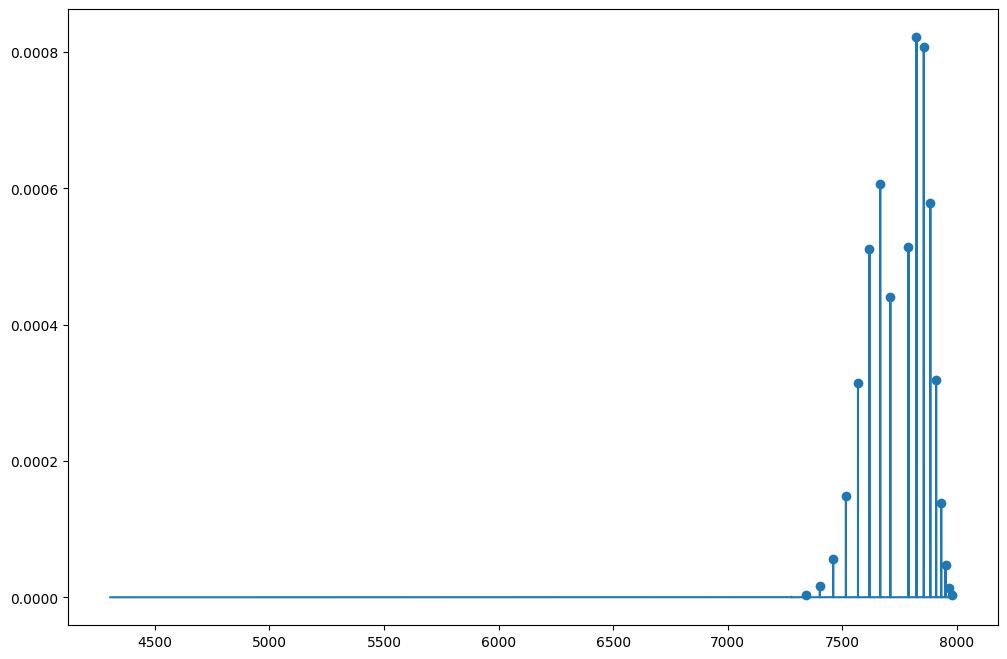

In [3]:
peaks, _ = find_peaks(y,height=0,prominence=1e-6)
# Criando o gráfico interativo
#fig = px.line(x=x, y=y, labels={'x': 'Número de onda', 'y': 'Intensidade'}, title="Espectro com picos detectados")
##
## Adicionando os picos como pontos
#fig.add_scatter(x=x[peaks], y=y[peaks], mode='markers', marker=dict(color='red', size=6), name='Picos')
##
## Exibindo o gráfico interativo
#fig.show()


plt.figure(figsize=(12,8))
plt.plot(x,y)
plt.scatter(x = x[peaks], y = y[peaks])

In [4]:
#centros = x[peaks]
#intensidades = y[peaks]
#
#
#indice_linha = 2
#line = sl.separa_pontos_manual(centro = centros[indice_linha], linha= intensidades[indice_linha], spec_mensurado= pd.DataFrame(spec, columns=['wavenumber','intensity']))
#
#x_sample = line['ex']
#y_sample = line['ey']
#
#_, result , _= sl.fit_raia(data = y_sample, ex = x_sample, chute_centro = centros[indice_linha])
#
#x_sample,y_sample = sl.interpolar(x_sample,y_sample)
#
## Criando o gráfico interativo
#fig = px.line(x=x, y=y, labels={'x': 'Número de onda', 'y': 'Intensidade'}, title="Espectro com picos detectados")
#
## Adicionando os picos como pontos
#fig.add_scatter(x=x_sample, y=y_sample,mode='markers', marker=dict(color='red', size=6), name='Picos')
#
## Exibindo o gráfico interativo
#fig.show()

In [5]:
modelo = tf.keras.models.load_model('../NN_modeling/(0.1.4)modelo.keras')

In [6]:
centros = x[peaks]
intensidades = y[peaks]
p = []
for i, centro in enumerate(centros):

    line = sl.separa_pontos_manual(centro = centros[i], linha= intensidades[i], spec_mensurado= pd.DataFrame(spec, columns=['wavenumber','intensity']))

    x_sample = line['ex']
    y_sample = line['ey']

    _, result , _= sl.fit_raia(data = y_sample, ex = x_sample, chute_centro = centros[i])

    x_sample,y_sample = sl.interpolar(x_sample,y_sample)

    primeira_derivada = sl.derivar(x_sample, y_sample)
    segunda_derivada  = sl.derivar(x_sample, primeira_derivada)
    
    primeira_derivada = np.array(primeira_derivada)
    segunda_derivada  = np.array(segunda_derivada)
    
    statistics = sl.statistics_calculus(x_sample,y_sample)
    stats = list(statistics.values())
    y_sample = y_sample.reshape(50,1)
    primeira_derivada = primeira_derivada.reshape(50,1)
    segunda_derivada = segunda_derivada.reshape(50,1)
    
    X = np.concatenate([y_sample,primeira_derivada,segunda_derivada],axis=1).reshape(50,3)
    
    X = tf.convert_to_tensor(X)
    stats = tf.convert_to_tensor(stats)
    stats = tf.expand_dims(stats,0)
    X = tf.expand_dims(X,0)

    predito = modelo.predict([X,stats],verbose = 3)

    perfil_i = np.argmax(predito[0])

    if perfil_i == 0 :
        perfil = 'Gauss'
    elif perfil_i == 1:
        perfil = 'Lorentz'
    else:
        perfil = 'Voigt'

    p.append(perfil_i)
    sreal = result.params["sigma"].value
    greal = result.params["gamma"].value
    sigma = predito[1][0][0]
    gamma = predito[2][0][0]
    print(f'Perfil: {perfil}\nSigma Predito: {sigma} / Sigma real: {sreal} -> Diferença: {np.abs(sreal-sigma)}\nGamma Predito: {gamma} / Gamma real: {greal} -> Diferença: {np.abs(greal-gamma)}' )
    print('-'*100)


Sucesso ajuste: True
Perfil: Gauss
Sigma Predito: 0.0015491917729377747 / Sigma real: 0.008586368828616742 -> Diferença: 0.007037177055678967
Gamma Predito: 0.0 / Gamma real: 4.424554803206249e-06 -> Diferença: 4.424554803206249e-06
----------------------------------------------------------------------------------------------------
Sucesso ajuste: True
Perfil: Gauss
Sigma Predito: 0.021245352923870087 / Sigma real: 0.00865420592735977 -> Diferença: 0.012591146996510316
Gamma Predito: 0.0 / Gamma real: 1.1177550730989694e-05 -> Diferença: 1.1177550730989694e-05
----------------------------------------------------------------------------------------------------
Sucesso ajuste: True
Perfil: Gauss
Sigma Predito: 0.01997380703687668 / Sigma real: 0.008723156213874539 -> Diferença: 0.01125065082300214
Gamma Predito: 0.0 / Gamma real: 9.676343088127481e-06 -> Diferença: 9.676343088127481e-06
----------------------------------------------------------------------------------------------------
S

<AxesSubplot: ylabel='count'>

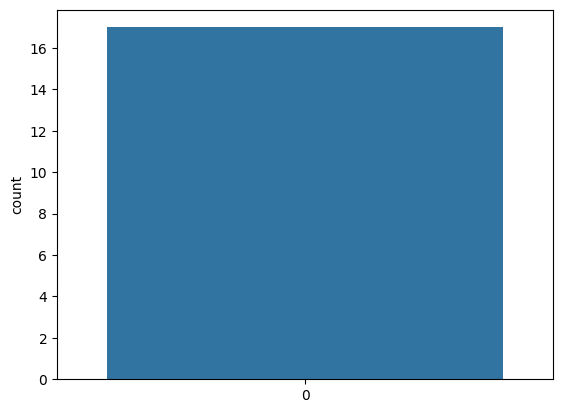

In [7]:
sns.countplot(x=p)

In [8]:
result